In [3]:
# IGNORE THIS CELL WHICH CUSTOMIZES LAYOUT AND STYLING OF THE NOTEBOOK !
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None
from IPython.core.display import HTML; HTML(open("custom.html", "r").read())

# Chapter 7: Regression

Regression belongs like classification to the field of supervised learning. 

<div class="alert alert-block alert-warning">
<i class="fa fa-info-circle"></i>&nbsp; 
<strong>Regression predicts numerical values</strong> 
in contrast to classification which predicts categories.
</div>

<img src="./images/30416v.jpg" title="made at imgflip.com" width=35%/>

<div class="alert alert-block alert-warning">
<i class="fa fa-info-circle"></i>&nbsp; 
    Other main differences are:

* Different quality measures
* Other algorithms
</div>

## Example: Salmon weight

The dataset `data/salmon.csv` holds measurements of `circumference`, `length` and `weight` for  `atlantic` and `sockeye` salmons.

Our goal is to predict `weight` based on the other three features.

In [4]:
import pandas as pd

df = pd.read_csv("data/salmon.csv")
df.head()

circumference  length      kind  weight
0           19.0    59.5   sockeye     5.1
1           18.0    53.0   sockeye     4.1
2           28.0    75.5  atlantic     9.1
3           33.5    89.0  atlantic    15.6
4           23.5    63.0  atlantic     5.2

In [5]:
df.tail()

circumference  length      kind  weight
95           24.0    76.0  atlantic     6.7
96           18.5    67.0   sockeye     5.0
97           18.0    59.5   sockeye     4.7
98           20.0    64.5  atlantic     4.1
99           23.0    75.0   sockeye     7.2

Let us inspect the features and their distributions:

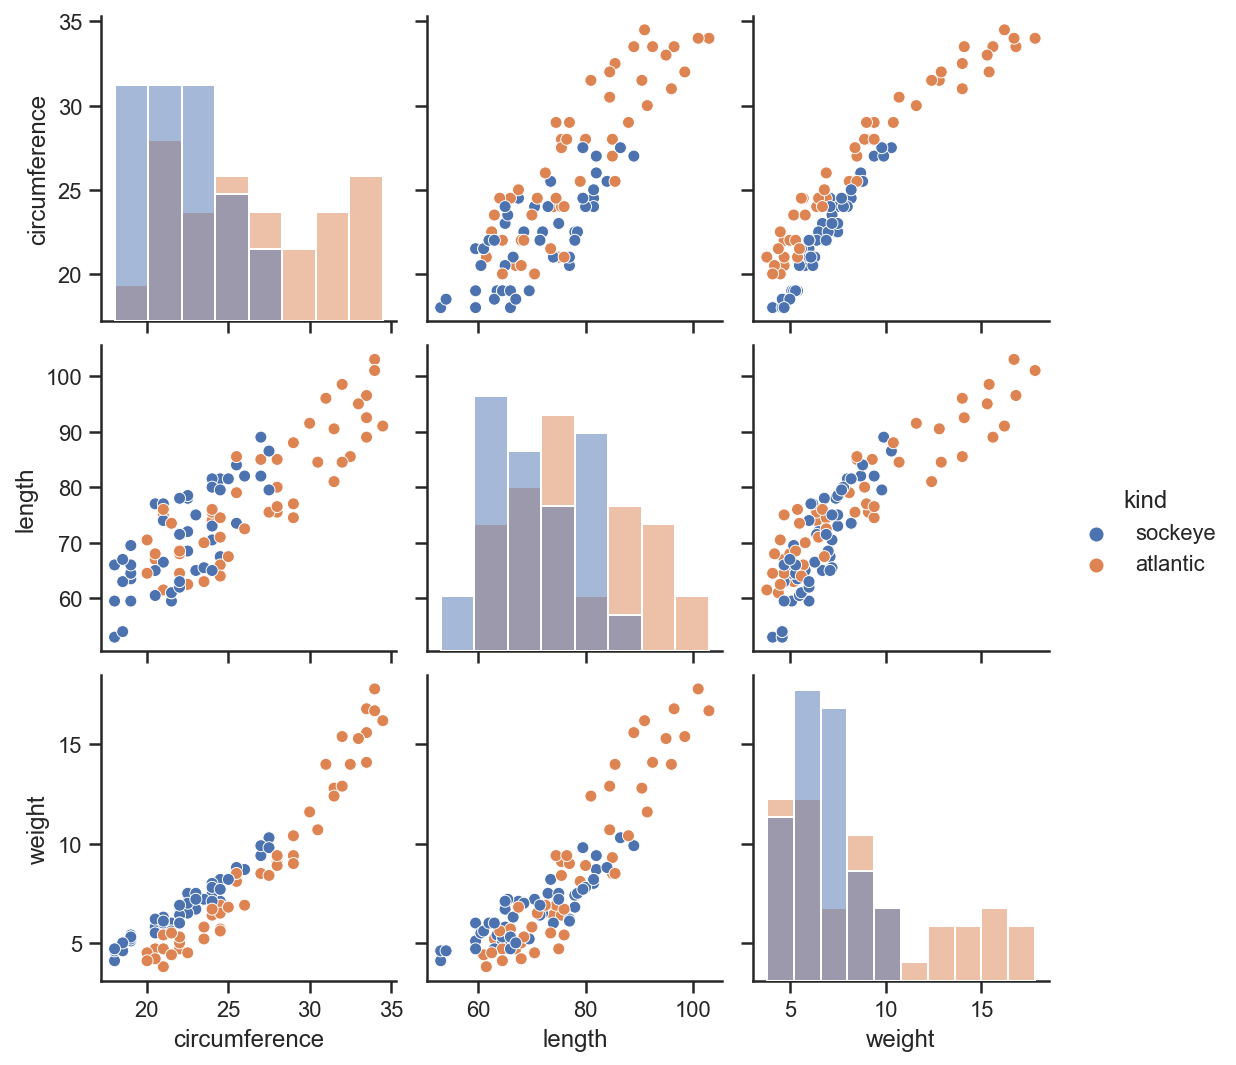

In [6]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(df, hue="kind", diag_kind="hist");

In contrast to our previous examples, our data set contains a non-numerical text column `kind`.

As discussed before a common method to encode categorical features is **one-hot-encoding**, <code>sklearn.preprocessing.OneHotEncoder</code> is a preprocessor which transforms a categorical feature to this encoding:


In [7]:
from sklearn.preprocessing import OneHotEncoder

features = df.iloc[:, :-1]
values = df.iloc[:, -1]

# needs 2d data structure, features.iloc[2] has dimension 1
encoder = OneHotEncoder(sparse=False)
one_hot = encoder.fit_transform(features.iloc[:, 2: 3]) 

one_hot[:5, :]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

So the one-hot encoder computes two columns with exclusive flags 0 and 1.

In [8]:
features["is_atlantic"] = one_hot[:, 0]
features["is_sockeye"] = one_hot[:, 1]

features.head()

circumference  length      kind  is_atlantic  is_sockeye
0           19.0    59.5   sockeye          0.0         1.0
1           18.0    53.0   sockeye          0.0         1.0
2           28.0    75.5  atlantic          1.0         0.0
3           33.5    89.0  atlantic          1.0         0.0
4           23.5    63.0  atlantic          1.0         0.0

In [9]:
# we remove the categorical column now:
del features["kind"]

Now we prepare the data for training and testing:

In [10]:
from sklearn.model_selection import train_test_split

(features_train, features_test, 
 values_train, 
 values_test) = train_test_split(features, values, random_state=42)

Without further explanation we pick a regression algorithm, more about regrssion algorithms will be discussed later:

In [11]:
from sklearn.kernel_ridge import KernelRidge
kr = KernelRidge(alpha=.001, kernel="rbf", gamma=.05)

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; Regression methods in <code>scikit-learn</code> also have <code>fit</code> and <code>predict</code> methods. Thus cross validation, pipelines and hyperparameter-optimization will be available.
    
</div>

In [12]:
kr.fit(features_train, values_train)
predicted = kr.predict(features_test)

Let us plot how good given and predicted values match on the training data set (sic !).

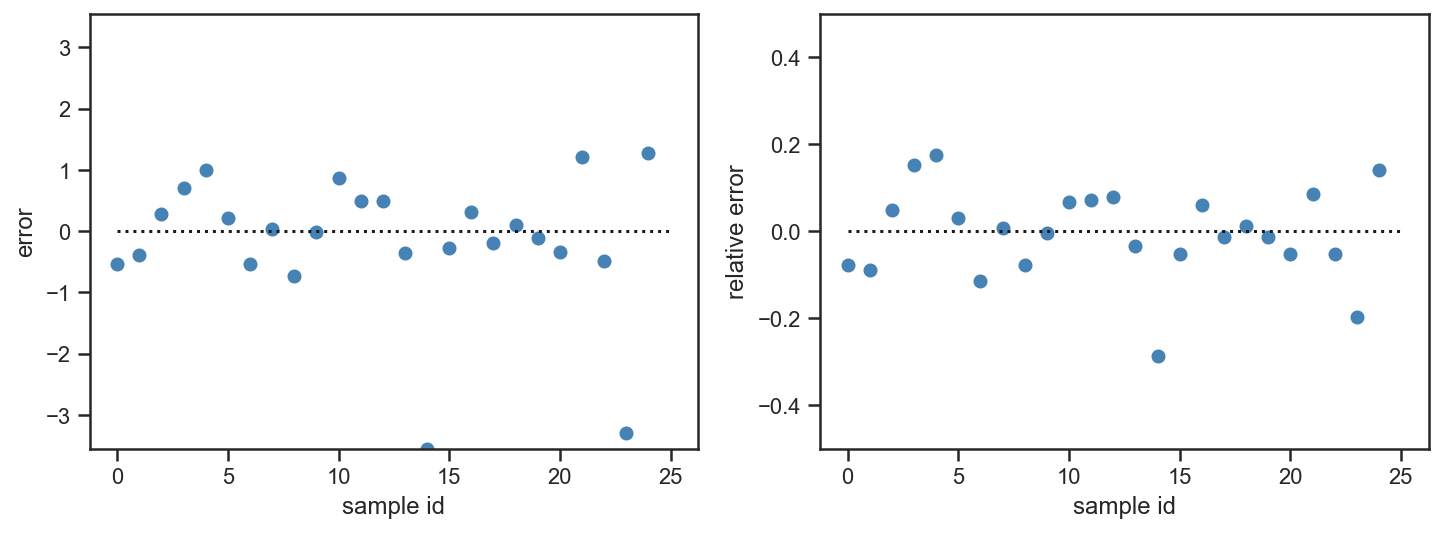

In [13]:
import numpy as np


def plot_fit_quality(values_test, predicted):
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)

    x = np.arange(len(predicted))
    plt.scatter(x, predicted - values_test, color='steelblue', marker='o') 

    plt.plot([0, len(predicted)], [0, 0], "k:")
    
    max_diff = np.max(np.abs(predicted - values_test))
    plt.ylim([-max_diff, max_diff])
    
    plt.ylabel("error")
    plt.xlabel("sample id")

    plt.subplot(1, 2, 2)

    plt.scatter(x, (predicted - values_test) / values_test, color='steelblue', marker='o') 
    plt.plot([0, len(predicted)], [0, 0], "k:")
    plt.ylim([-.5, .5])
      
    plt.ylabel("relative error")
    plt.xlabel("sample id")

    
plot_fit_quality(values_test, predicted)

For assessing the quality of the predictions of a regression method, we can use multiple methods which we will discuss later in this script.

For our current example we compute the average absolute difference between given values $y_i$ and predicted values  $\hat{y}_i$:

$$
\frac{1}{n} \left(\, |y_1 - \hat{y}_1| \, + \, |y_2 - \hat{y}_2| \, + \, \ldots \,+ \,|y_n - \hat{y}_n| \,\right)
$$


In [14]:
import numpy as np

error = np.sum(np.abs(predicted - values_test)) / len(values_test)
print(error)

0.7122581321318665


## Metrics / error measures

For the classification metrics we introduced (like accuracy, precision, recall, F1) higher numbers indicated better classification performance. 

Most regression metrics turn this upside down. E.g. smaller values indicate a better regression model.

|                |                                   |                        |   |   |
|----------------|-----------------------------------|------------------------|---|---|
| classification | accuracy, F1, ...                 | the larger the better  |   |   |
| regression     | average absolute difference, ...  | the smaller the better |   |   |


To harmonize this we can flip the sign of the regression scores, e.g.

In [22]:
error = -np.sum(np.abs(predicted - values_test)) / len(values_test)
print(error)

-0.7122581321318484


Now a average regression score 0.3 which is better then 0.4 also becomes larger when we flip the sign:

In [21]:
-0.3 > -0.4

True

The benefit is that we can use hyperparameter optimization functions from `scikit-learn` (which select configurations which yield a large score) without further modification. 

   

`scikit-learn` offers the following metrics for measuring regression quality:

### 1. Mean absolute error

This is the metric we used before. Taking absolute values before adding up the deviatons assures that deviations with different signs can not cancel out.

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>mean absolute error</strong> is defined as 


$$
\frac{1}{n} \left(\, |y_1 - \hat{y}_1| \, + \, |y_2 - \hat{y}_2| \, + \, \ldots \,+ \,|y_n - \hat{y}_n| \,\right)
$$


</div>


The name of the corresponding score in `scikit-learn` is `neg_mean_absolute_error`.


### 2. Mean squared error

Here we replace the absolute difference by its squared difference. Squaring also insures positive differeces.

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>mean squared error</strong> is defined as 



$$
\frac{1}{n} \left(\, (y_1 - \hat{y}_1)^2 \, + \, (y_2 - \hat{y}_2)^2 \, \, \ldots \,+ \,(y_n - \hat{y}_n)^2 \,\right)
$$


</div>



This measure is more sensitive to outliers: A few larger differences contribute more significantly to a larger mean squared error. The name of the corresponding score in `scikit-learn` is `neg_mean_squared_error`.


### 3. Median absolute error

Here we replace mean calculation by median. 

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>median absolute error</strong> is defined as 



$$
\text{median}\left(\,|y_1 - \hat{y}_1|, \,|y_2 - \hat{y}_2|, \,\ldots, \,|y_n - \hat{y}_n| \, \right)
$$


</div>


This measure is less sensitive to outliers than the metrics we discussed before: A few larger differences will not contribute significantly to a larger error value. The name of the corresponding score in `scikit-learn` is `neg_median_absolute_error`.

### 4. Mean squared log error

The formula for this metric can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error). 

This metric is recommended when your target values are distributed over a huge range of values, like popoluation numbers. 
The previous error metrics would put a larger weight on large target values. One could consider relative deviations to compensate such effects but relative deviations come with other problems like division by zero.


The name is `neg_mean_squared_log_error`


### 5. Explained variance and $r^2$-score

Two other scores to mention are *explained variance* and $r^2$-score. For both larger values indicate better regression results.

The formula for [r2 can be found here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score), the score takes values in the range $0 .. 1$. The name within `scikit-learn` is `r2`.

The formula for [explained variance](https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score), the score takes values up to $1$. The name within `scikit-learn` is `explained_variance`.

## Some algorithms from sklearn

- `sklearn.linear_model.LinearRegression` is a linear regression method, which only works well for target values which can be described as a linear combination of feature values.


- `sklearn.kernel_ridge.KernelRidge` is [documented here](https://scikit-learn.org/stable/modules/kernel_ridge.html#kernel-ridge). It combines the kernel trick from SVMs with classical least squares regression.


- `sklearn.svm.SVR` is an extension of support vector classification concept to regression, [you find examples here](https://scikit-learn.org/stable/modules/svm.html#svm-regression)


- `sklearn.neighbors.KNeighborsRegressor` extends the idea of nearest neighbour classification to regression: Search for similar data points in the learning data set and compute the predicted value from the values from the neighbourhood, e.g. by averaging or by linear interpolation. [Documentation is available here](https://scikit-learn.org/stable/modules/neighbors.html#regression)


- `sklearn.tree.DecisionTreeRegressor` expands the concept of decision trees to regression [is documented here](https://scikit-learn.org/stable/modules/tree.html#regression).




## A full pipeline

Let us now try to find a good regressor using `scikit-learn`s hyper-parameter tuning:

cross val score: -0.7568859642342642


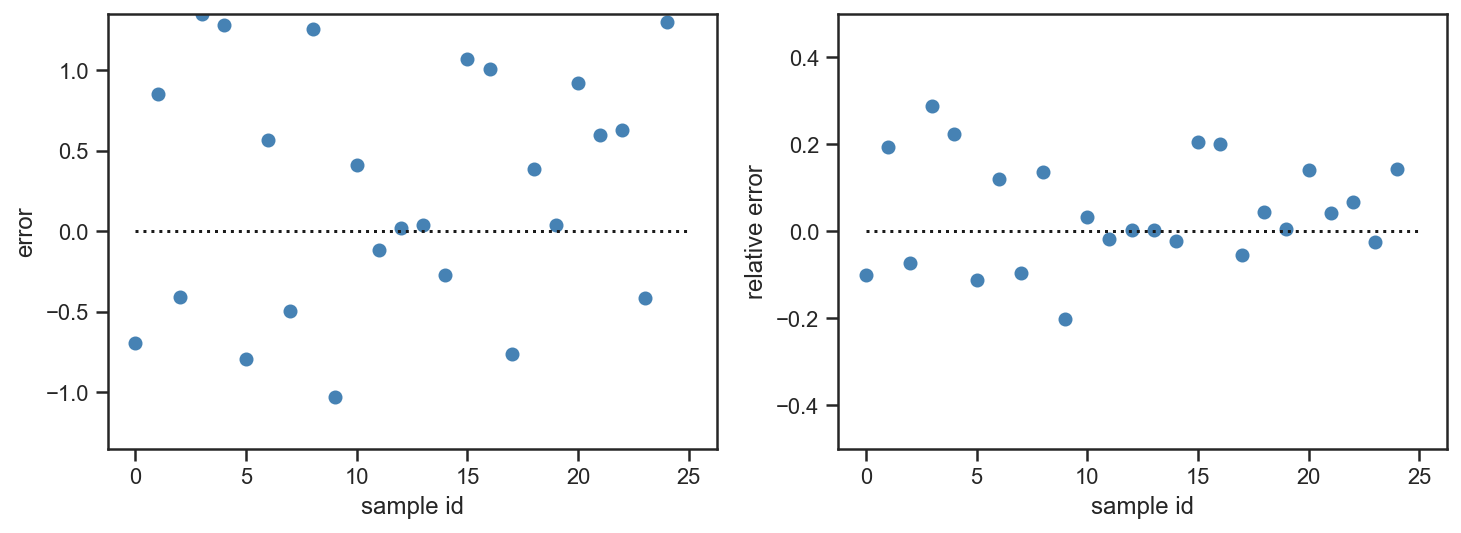

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA


def eval_regression(p, features, values):
    score = cross_val_score(p, features, values, scoring="neg_median_absolute_error", cv=4).mean()
    print("cross val score:", score)
  
    predicted = p.fit(features_train, values_train).predict(features_test)
    plot_fit_quality(values_test, predicted)

    
p = make_pipeline(PolynomialFeatures(2), PCA(2), LinearRegression())
eval_regression(p, features, values)

In [31]:
p = make_pipeline(PolynomialFeatures(), PCA(), LinearRegression())

param_grid = {'polynomialfeatures__degree': range(3, 6),
              'pca__n_components': range(3, 11),
             }

{'pca__n_components': 10, 'polynomialfeatures__degree': 3}
cross val score: -0.22752607270361858


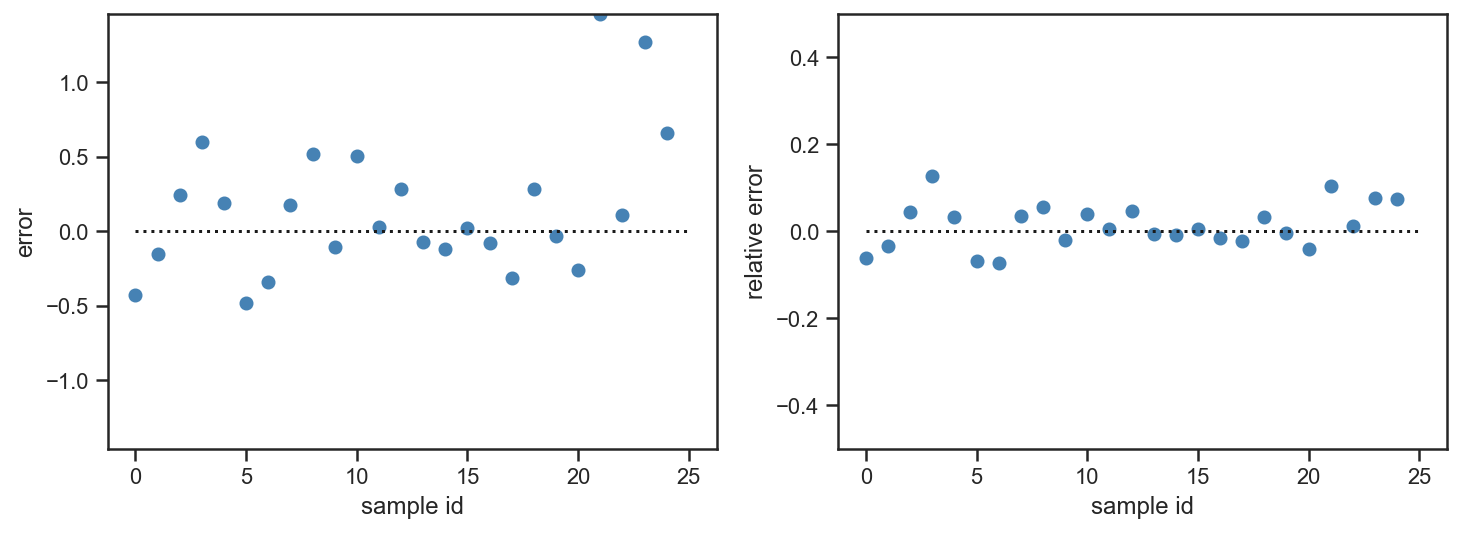

In [32]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(p, param_grid, scoring="neg_median_absolute_error", cv=4, n_jobs=4)

search.fit(features, values)

print(search.best_params_)
eval_regression(search, features, values)

## Exercise section

- Play with the examples above and try different algorithms, metrics and pipelines.


### Optional exercise: Timeseries prediction

The file  `data/sales.csv` holds sales data of a swiss sports shop selling skiing equipment. The time axis is in units of months, starting with January.

* Load the data and plot sales value over months

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sales_data = pd.read_csv("data/sales.csv")
sales_data.head()

month     sales
0      0  1.085941
1      1  0.645099
2      2  0.447248
3      3  0.597362
4      4  0.134709

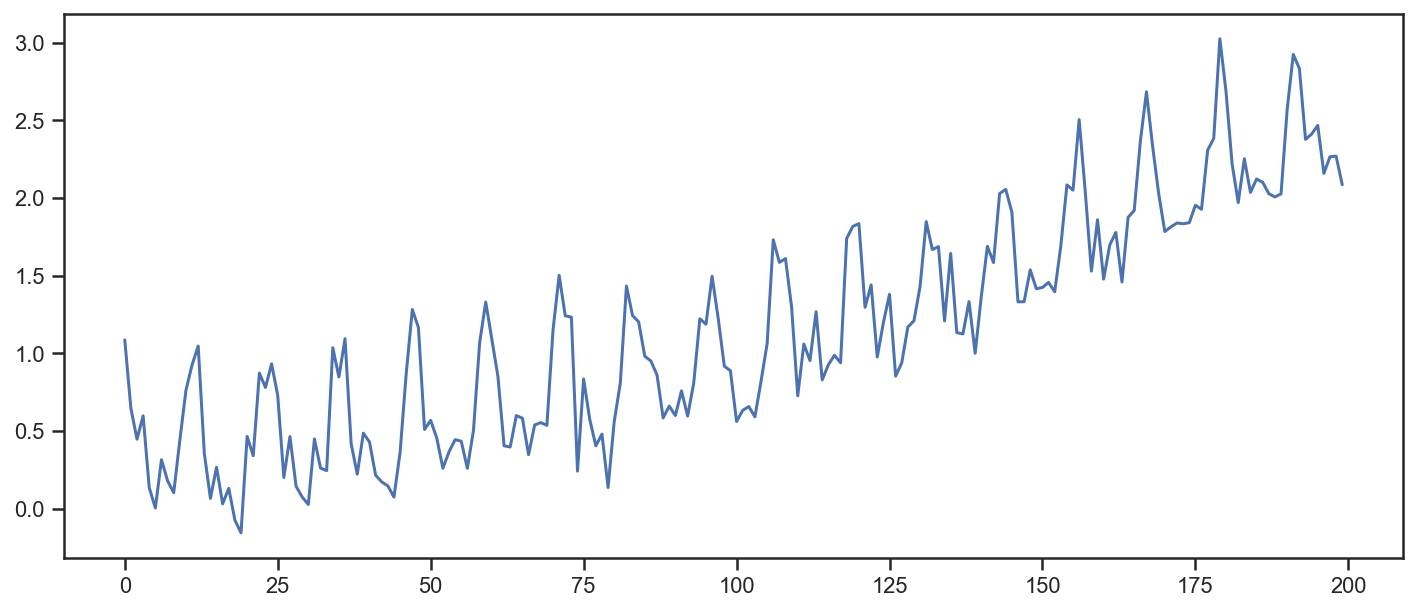

In [34]:
months = sales_data.iloc[:, 0].values
sales = sales_data.iloc[:, 1].values

plt.figure(figsize=(12, 5))
plt.plot(months, sales);

<div style="font-size: 130%;">Approach for time series forecasting</div>

**Advice**: you might want to read the full instructions several times to understand the concept.

We want to learn from our single time series of sales by looking at its smaller parts and take sales value that comes after each such part (window) as an expected prediction.

More formally, we learn to predict n-th value in the series $s_{n}$ based on few previous values `W`: $s_{n - W}, s_{n - W + 1} \ldots s_{n - 1}$. `W` is a parameter called *window size*.

E.g. for window size $W$ = 3 we create a feature matrix `X` based on sales values:

    s_0, s_1, s_2
    s_1, s_2, s_3
    s_2, s_3, s_4
    ...
    
and a vector of target values `y` as follows:

    s_3
    s_4
    s_5
    ...
    
Here is a function which takes sales vector `s_0, s_1, ...` and window size `W` and returns features matrix `X` and the right hand side `y`:

In [35]:
def create_feature_matrix_and_target_values(sales, window_size):
    features = np.zeros((len(sales) - window_size, window_size))

    for i in range(len(sales) - window_size):
        features[i] = sales[i: i + window_size]
        
    return features, sales[window_size:]

In [36]:
def test():
    X, y = create_feature_matrix_and_target_values(sales, 4)
    assert np.all(X[0] == sales[:4])
    assert np.all(X[1] == sales[1:5])
    assert np.all(X[2] == sales[2:6])
    assert np.all(X[-1] == sales[-5: -1])
    
    assert np.all(y[0] == sales[4])
    assert np.all(y[-1] == sales[-1])
    
test()

- Find optimal configurations (use the `r2` metric) for the regressors `Lasso`, `SVR` and `KernelRidge(kernel="rbf")` and several window sizes. 
- For every month $i$ we want to compare the known value of $s_i$ and the predicted value for this month. To that end, plot both sales and predicted time series on one plot, and plot sales against predicted points as a scatter plot.

In [37]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from sklearn.metrics import r2_score

# ...

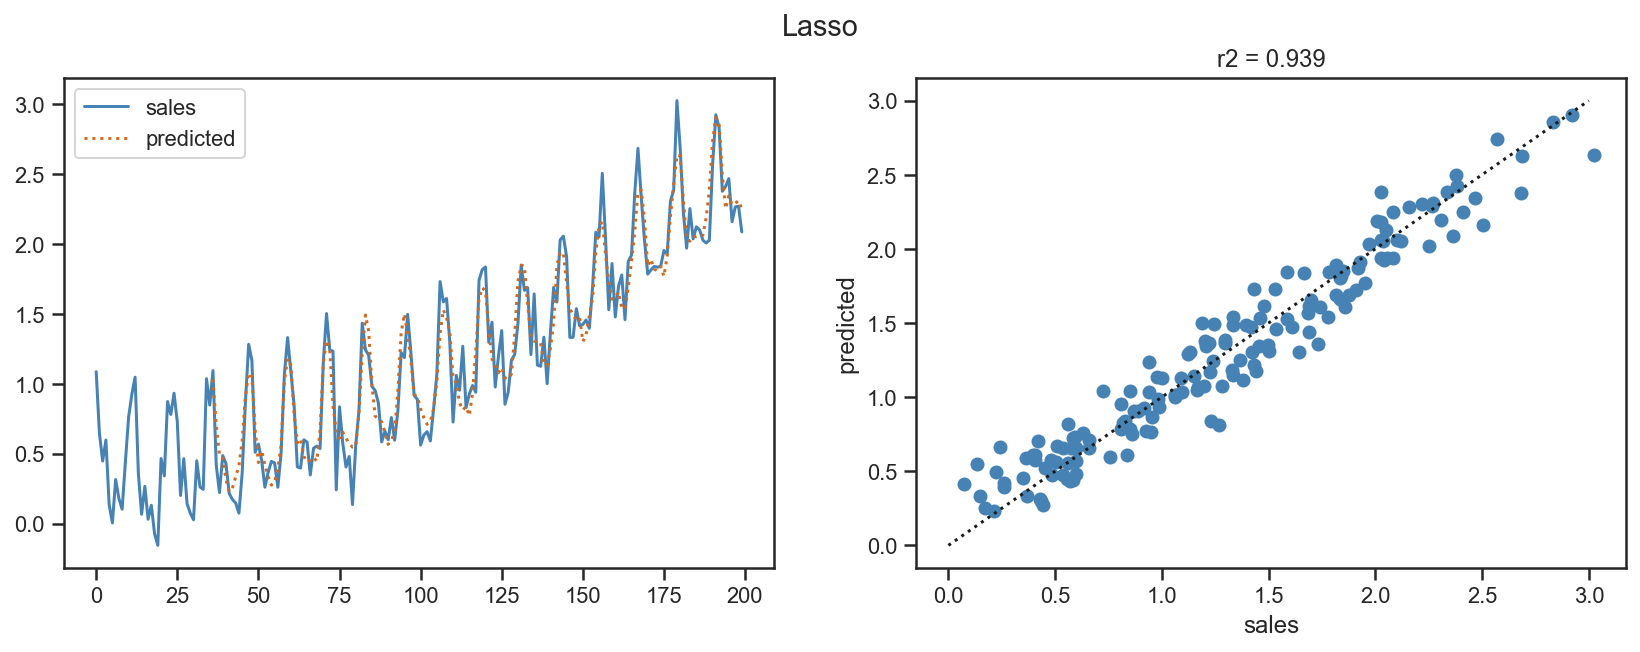

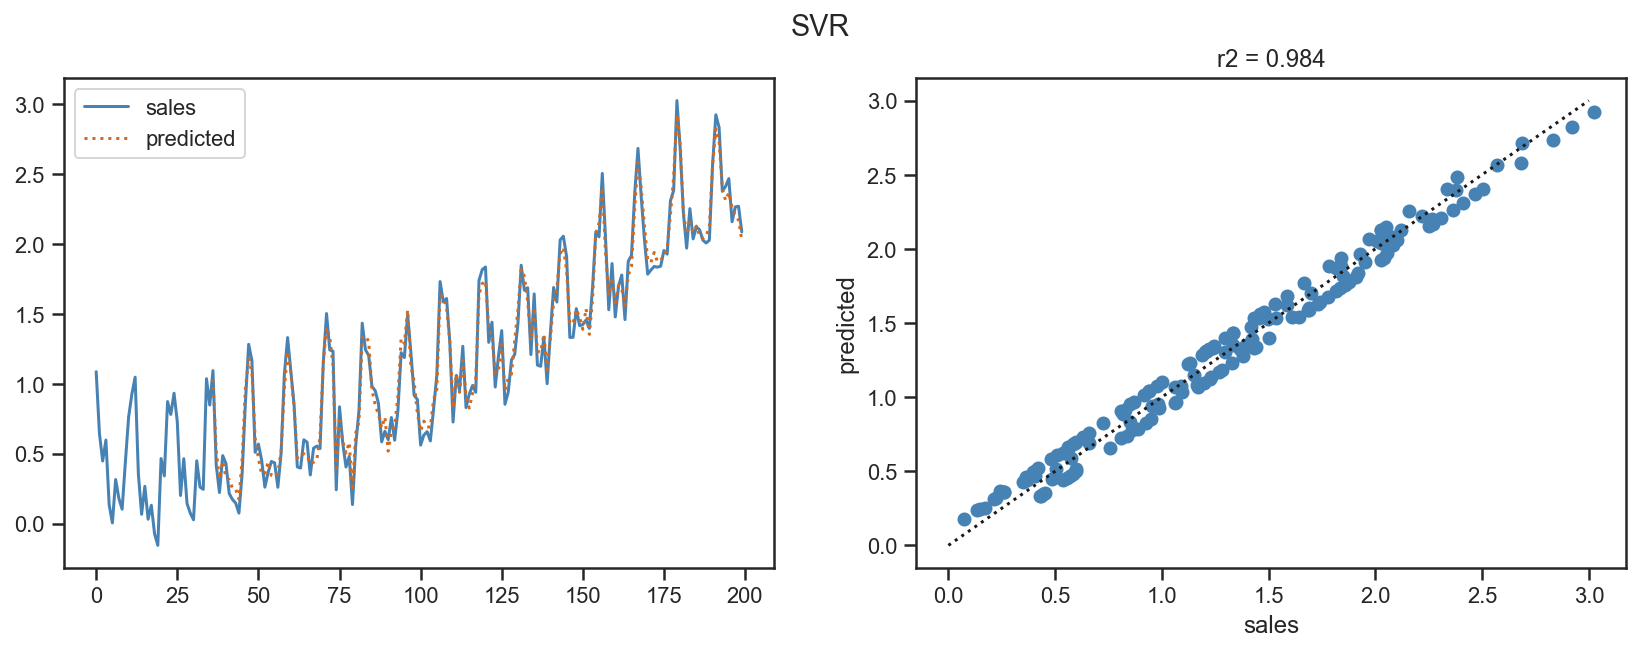

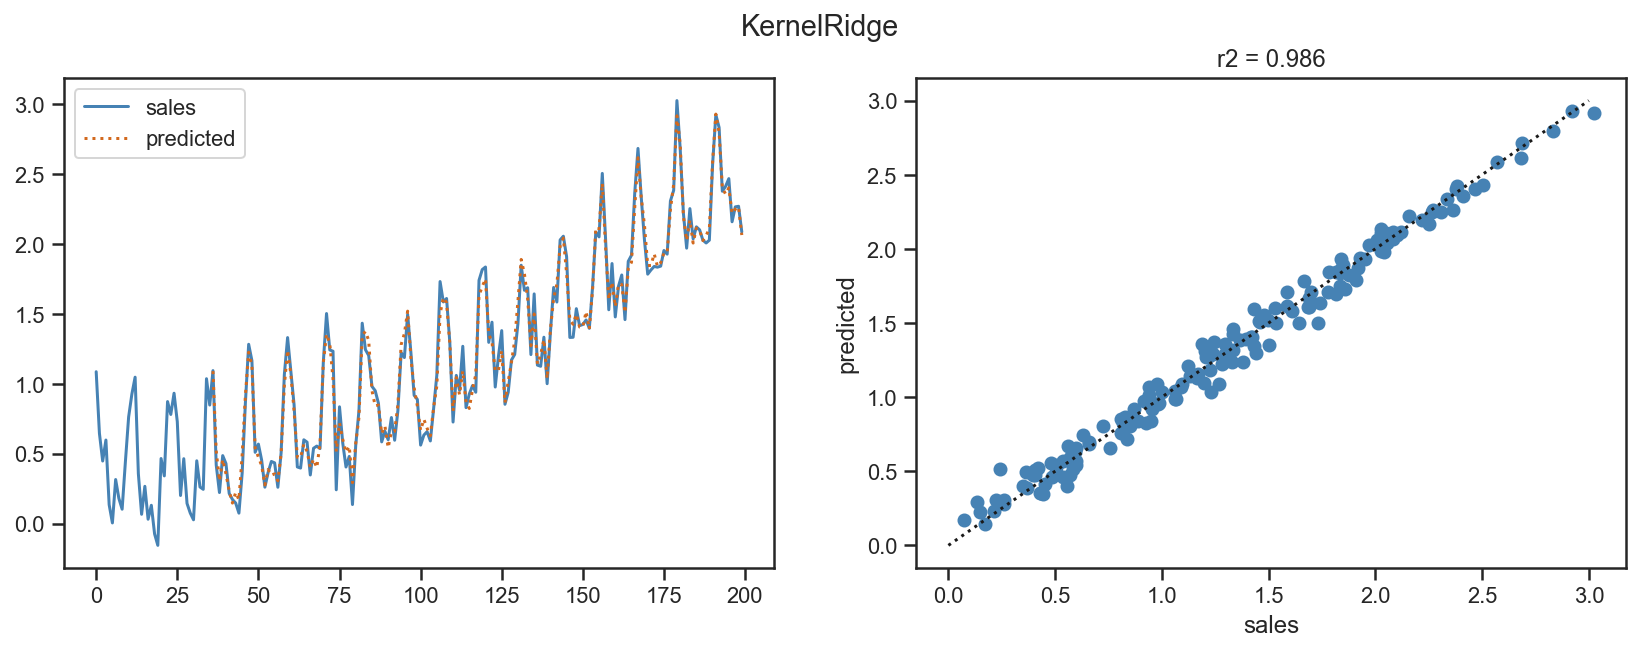

In [38]:
lasso_grid = {'alpha' : 10 ** np.linspace(-2, 3, 30)}
svr_grid = {'C': 10 ** np.linspace(-4, 2, 30)}
kernel_ridge_grid = {'alpha' : 10 ** np.linspace(-4, 3, 30)}

WINDOW_SIZE = 36
X, y = create_feature_matrix_and_target_values(sales, WINDOW_SIZE)

def main(X, y):
    
    regressors = []
    
    for regressor, param_grid in [(Lasso(), lasso_grid),
                           (SVR(), svr_grid),
                           (KernelRidge(kernel="rbf"), kernel_ridge_grid)
                          ]:
        search = GridSearchCV(regressor, param_grid, scoring="r2", cv=5)
        search.fit(X, y)
        
        # we predict on the learning data set to get a general
        # "feeling" how well the regressors work
        predicted = search.predict(X)
        
        plot_regression(regressor.__class__.__qualname__, predicted)
        
        regressors.append(search)

    return regressors

        
def plot_regression(title, predicted):
    plt.figure(figsize=(14, 4.5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    
    plt.plot(months, sales, label='sales', color="steelblue")
    plt.plot(months[WINDOW_SIZE:], predicted, color="chocolate", linestyle=":", label='predicted');
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(sales[WINDOW_SIZE:], predicted, color="steelblue")
    r2 = r2_score(sales[WINDOW_SIZE:], predicted)
    
    plt.title("r2 = {:.3f}".format(r2))
    plt.plot([0, 3], [0, 3], "k:")
    plt.xlabel('sales')
    plt.ylabel('predicted')

    
regressors = main(X, y)

Now we want to use our model to get long term predictions starting at month `N`, with a given window size `W`.

We will be iteratively predicting next value after the window and shifting the window by one. We execute the following steps:

1. predict first value after given time window.
2. update data window: shift by one time step, thus: discard the first entry and append the newly predicted value
3. continue with step 1.


We demonstrate this for `W=4` and `N=100` to predict values `z_101`, `z_102`, ...:

<div style="margin-left: 1em;">
<code>
predict <span style="color: green; ">z_101</span> from s_097, s_098, s_099, s_100
predict <span style="color: green; ;">z_102</span> from s_098, s_099, s_100, <span style="color: green; ">z_101</span>
predict <span style="color: green; ">z_103</span> from s_099, s_100, <span style="color: green; ">z_101, z_102</span>
predict <span style="color: green; ">z_104</span> from s_100, <span style="color: green; ">z_101, z_102, z_103</span>
predict <span style="color: green; ;">z_105</span> from <span style="color: green; ">z_101, z_102, z_103, z_104</span>
...                                          
</code> 
</div>


- Implement this procedure and plot forecasts vs real data for different regression algorithms and window sizes.
     
     

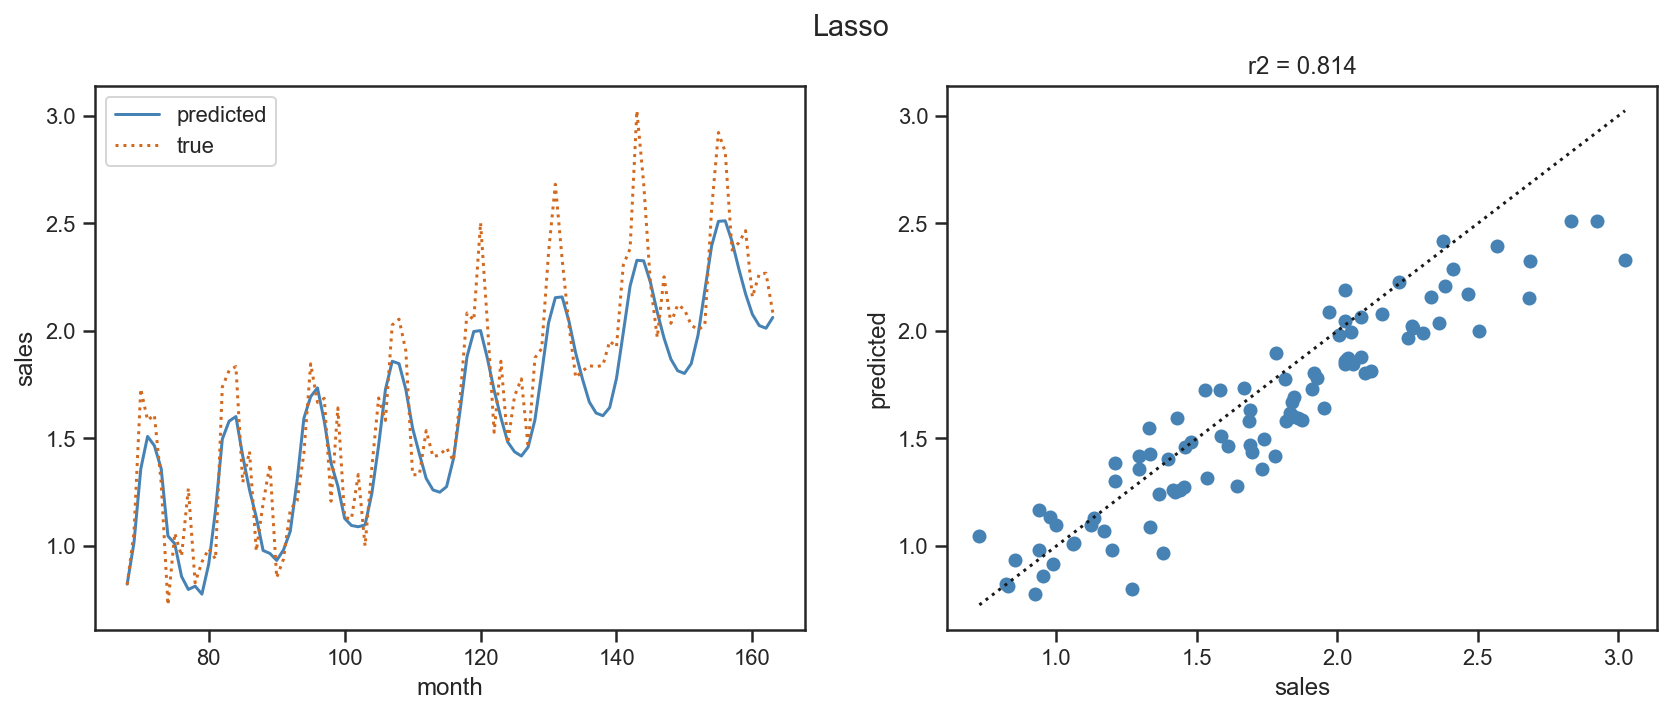

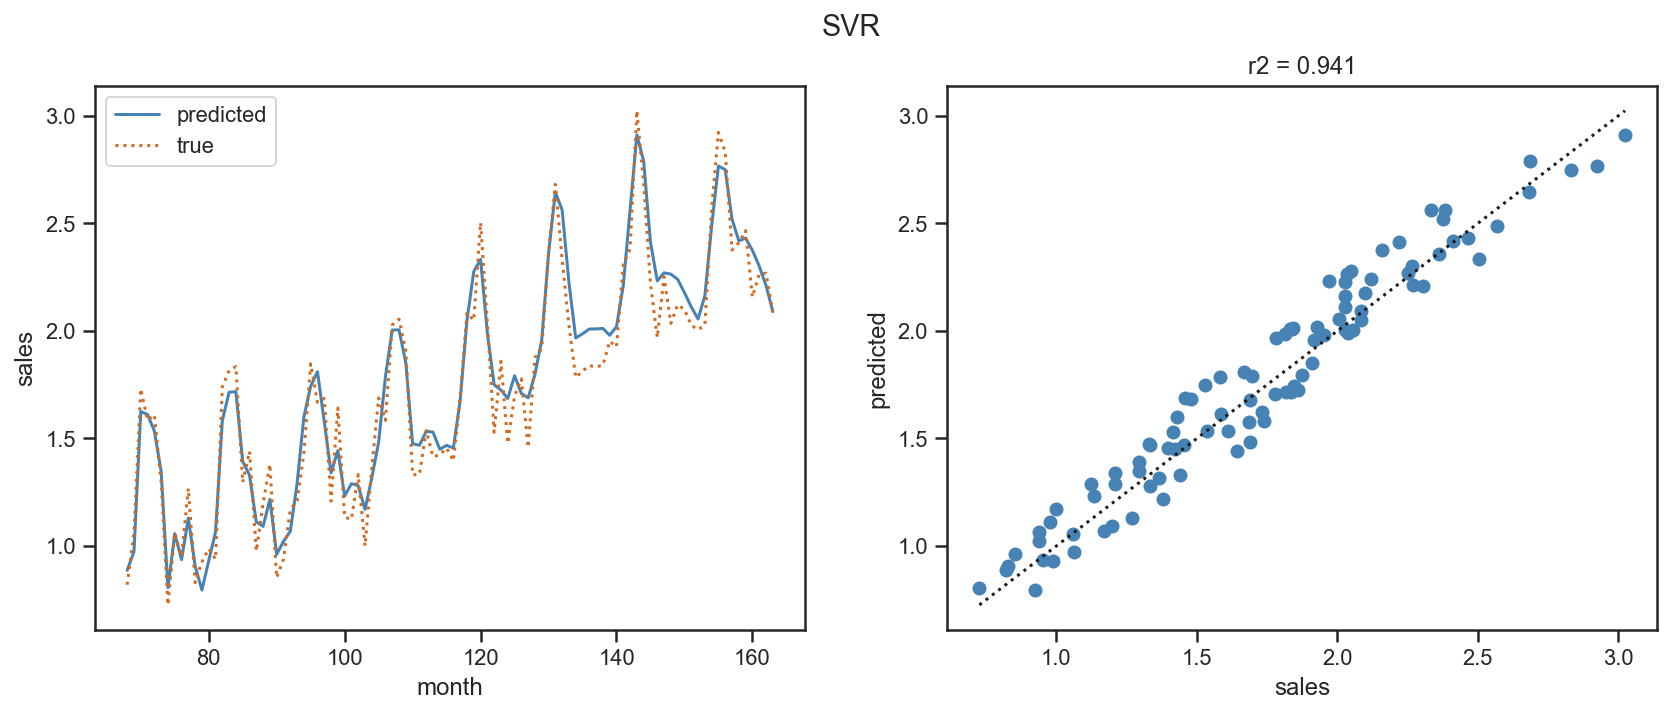

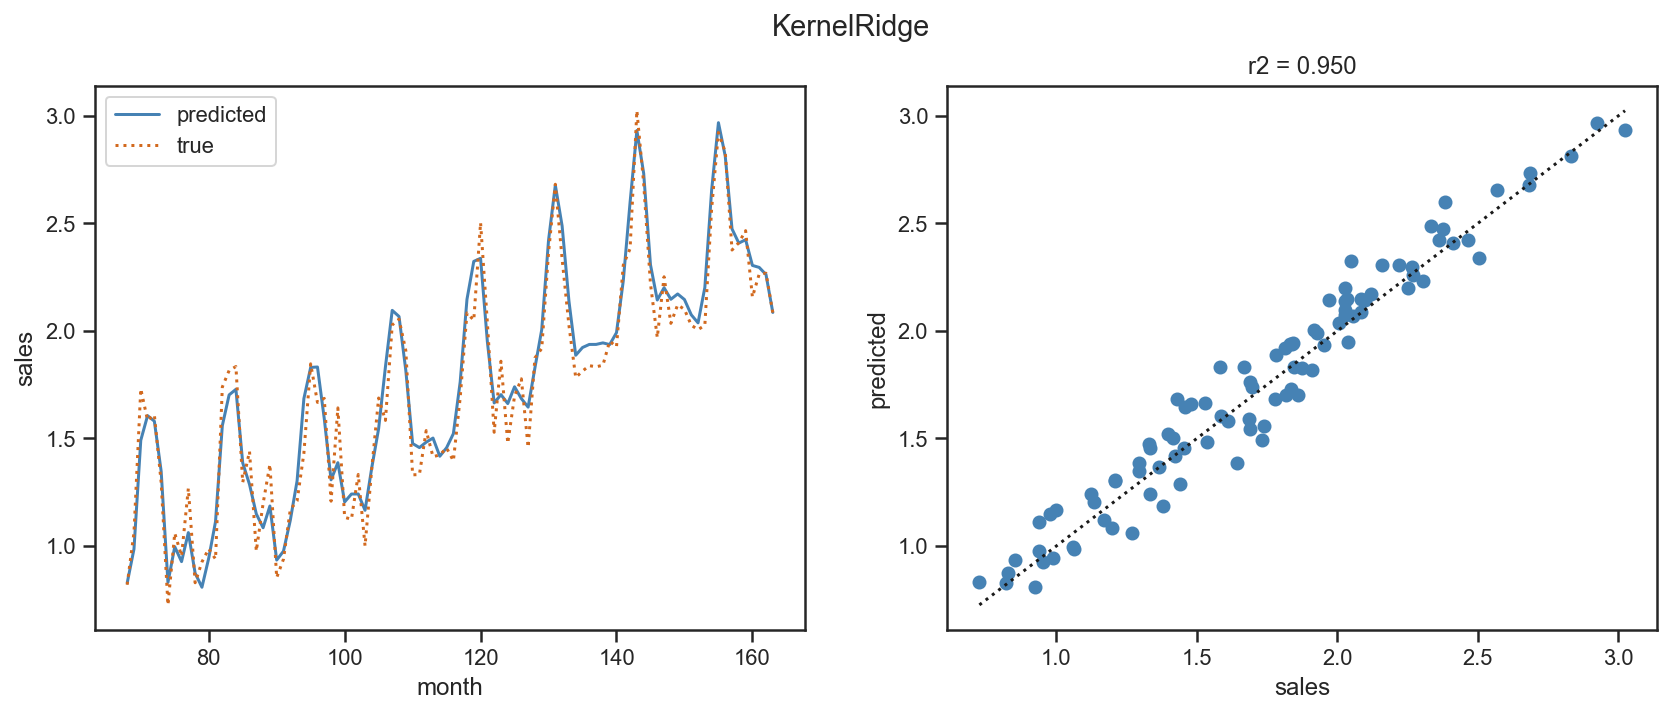

In [39]:
# start from line 96 in our feature matrix:
NLAST = 96

def forecast(X, y, regressor, n_last):
    
    # we crate a copy because we change below content
    # current_window in place. Without copy we would
    # also change X!
    current_window = X[-n_last, :].copy() 
   
    predicted = []

    for k in range(n_last):
        new = regressor.predict(current_window[None, :])
        predicted.append(new)
        # this relates to the comment above! here we
        # modify the window data in place:
        current_window[:-1] = current_window[1:]
        current_window[-1] = new
        
    return np.array(predicted).flatten(), y[-n_last:]


def forecast_and_plot(regressor, n_last):
    predicted, correct = forecast(X, y, regressor, n_last)

    x_axis = list(range(len(y)))[-n_last:]

    plt.figure(figsize=(14, 5))    
    plt.subplot(1, 2, 1)    
    plt.plot(x_axis, predicted, color="steelblue", label='predicted')
    plt.plot(x_axis, correct, color="chocolate", linestyle=":", label='true');
    plt.legend();
    plt.xlabel("month")
    plt.ylabel("sales")

    plt.subplot(1, 2, 2)
    plt.scatter(correct, predicted, color='steelblue')
    
    r2 = r2_score(correct, predicted)
    plt.title("r2 = {:.3f}".format(r2))
    plt.xlabel("sales")
    plt.ylabel("predicted")

    mi, ma = np.min(correct), np.max(correct)
    plt.plot([mi, ma], [mi, ma], 'k:');
    plt.suptitle(regressor.estimator.__class__.__qualname__)
    
    
for regressor in regressors:
    forecast_and_plot(regressor, NLAST)  

Copyright (C) 2019-2021 ETH Zurich, SIS ID